In [79]:
import numpy as np

class Household:
    def __init__(self, i, savings):
        self.i = i
        self.savings = savings

    def act(self):
        # self.goods_requested = [...]
        # random for now
        self.goods_requested = [0.1 for _ in firms]

    def step(self):
        global houses, firms, bank, gov, employment_matrix, skill_matrix, hiring_firms

        # starting out, or if we were laid off
        if sum([employment_matrix[self.i][j] for j, _ in enumerate(firms)]) == 0:
            if hiring_firms:
                # of the hiring firms, pick the one i'm best at
                j = max(hiring_firms, key=lambda x: skill_matrix[self.i][x])
                employment_matrix[self.i][j] = 1
                self.wage = firms[j].wage
            else:
                self.wage = 0

        self.goods_received = [
            min(
                self.goods_requested[j],
                (firm.inventory + firm.production) * self.goods_requested[j] / tot if (tot := sum([house.goods_requested[j] for house in houses])) else 0
            )
            for j, firm in enumerate(firms)
        ]

        expenditure = sum([self.goods_received[j] * firm.price for j, firm in enumerate(firms)])

        self.income = self.wage * labour_hours
        self.savings += bank.interest_rate * self.savings + self.income - expenditure - gov.tax_rate_house * self.income + gov.tax_credits[self.i]

    def comp_reward(self):
        gamma = 2.0  # risk aversion coefficient
        nu = 1 # weight on labour disutility
        mu = 1 # weight on savings utility

        def utility(x):
            return (x ** (1 - gamma)) / (1 - gamma)

        consumption = sum(self.goods_received)
        hours = labour_hours if self.wage > 0 else 0

        self.reward = utility(consumption) - nu * hours ** 2 + mu * utility(self.savings)

    def learn(self):
        pass


# TODO add exogenous shocks
class Firm:
    def __init__(self, i, wage, price, production, inventory, deposit):
        self.i = i
        self.wage = wage
        self.price = price
        self.production = production
        self.inventory = inventory
        self.deposit = deposit

        self.consumption_history = []

    def act(self):
        # self.price = ...
        # self.wage = ...
        pass

    def forecast_demand(self):
        # simple moving average of last 4 quarters for now
        return sum(self.consumption_history[-4:]) / 4 if len(self.consumption_history) >= 4 else sum(self.consumption_history) / len(self.consumption_history) if self.consumption_history else 0

    def step(self):
        global houses, bank, gov, employment_matrix, skill_matrix

        consumption = sum([house.goods_received[self.i] for house in houses])
        num_employees = sum([employment_matrix[j][self.i] for j, _ in enumerate(houses)])

        self.inventory += self.production - consumption
        self.production = (labour_hours * num_employees) ** alpha

        revenue = sum([house.goods_received[self.i] * self.price for house in houses])
        expenditure = self.wage * labour_hours * num_employees

        self.profit = revenue - expenditure
        self.deposit += bank.interest_rate * self.deposit + self.profit - gov.tax_rate_firm * max(0, self.profit)

        # hiring/firing
        self.consumption_history.append(consumption)
        forecast = self.forecast_demand()
        required_production = max(0, forecast - self.inventory)
        required = max(round(required_production ** (1 / alpha) / labour_hours), 1)
        current = sum([employment_matrix[j][self.i] for j, _ in enumerate(houses)])
        diff = required - current

        if diff > 0:
            hiring_firms.add(self.i)
        else:
            hiring_firms.discard(self.i)
            if diff < 0:
                # pick my worst-skilled workers
                diff *= -1
                employed = [j for j, _ in enumerate(houses) if employment_matrix[j][self.i] == 1]
                employed.sort(key=lambda x: skill_matrix[x][self.i])
                for j in employed[:diff]:
                    employment_matrix[j][self.i] = 0

    def comp_reward(self):
        chi = 1 # weight on inventory risk

        self.reward = self.profit - chi * self.price * self.inventory

    def learn(self):
        pass


class CentralBank:
    def __init__(self, interest_rate):
        self.interest_rate = interest_rate
        self.tot_price_history = []

    def act(self):
        # self.interest_rate = ...
        pass

    def step(self):
        global firms

        # calculate annual inflation with each step as one quarter
        cur_tot_price = sum([firm.price for firm in firms])
        self.annual_inflation = (cur_tot_price / self.tot_price_history[-4]) - 1 if len(self.tot_price_history) >= 4 else 0
        self.tot_price_history.append(cur_tot_price)

    def comp_reward(self):
        global firms

        lam = 1 # weight on production

        production = sum([firm.production for firm in firms])
        self.reward = - (self.annual_inflation - target_inflation) ** 2 + lam * production ** 2

    def learn(self):
        pass


class Government:
    def __init__(self, tax_rate_house, tax_rate_firm, tax_credits):
        self.tax_rate_house = tax_rate_house
        self.tax_rate_firm = tax_rate_firm
        self.tax_credits = tax_credits

    def act(self):
        # inputs: tax_rate_house, tax_rate_firm, tax_collected_house, tax_collected_firm, tax_credits

        # self.tax_rate_house = ...
        # self.tax_rate_firm = ...
        self.credit_distrib = [1 / len(houses) for _ in houses]  # equal distribution for now

    def step(self):
        global houses, firms, gov

        self.tax_collected_house = sum([gov.tax_rate_house * house.income for house in houses])
        self.tax_collected_firm = sum([gov.tax_rate_firm * max(0, firm.profit) for firm in firms])
        self.tax_credits = [my_credit_frac * xi * (self.tax_collected_house + self.tax_collected_firm) for my_credit_frac in self.credit_distrib]

    def comp_reward(self):
        global houses

        theta = 0.5 # interpolates between wellfare reward and credit reward

        # prioritarian social wellfare function
        def wellfare_fn(rewards):
            # make sure non-negative
            if (mini := np.min(rewards)) < 0:
                rewards = rewards - mini

            exponent = 0.5
            transformed = np.power(rewards, exponent)
            total = np.sum(transformed)

            if total == 0:
                return np.ones_like(rewards) / len(rewards)

            return transformed / total

        wellfare_weights = wellfare_fn([house.reward for house in houses])

        tot_wellfare = sum([weight * house.reward for weight, house in zip(wellfare_weights, houses)])
        tot_credit = sum([weight * credit for weight, credit in zip(wellfare_weights, self.tax_credits)])

        self.reward = theta * tot_wellfare + (1 - theta) * tot_credit

    def learn(self):
        pass

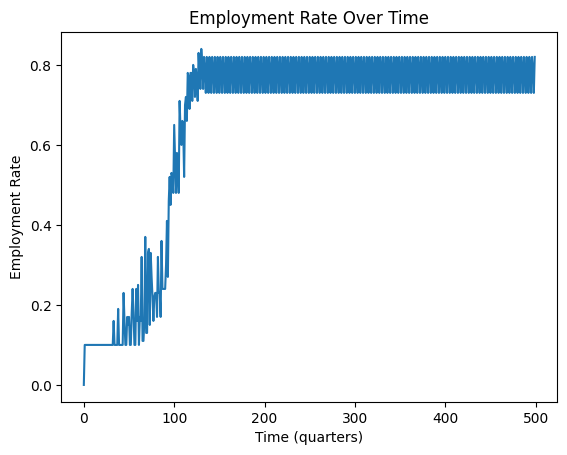

In [83]:
import random

labour_hours = 8 # static over time
alpha = 0.525 # production elasticity of labour
target_inflation = 0.02
xi = 0.2 # fraction of tax revenue to redistribute

houses = [Household(i, savings=random.uniform(1000, 5000)) for i in range(100)]
firms = [Firm(
    i,
    wage=random.uniform(15, 25),
    price=random.uniform(5, 15),
    production=random.uniform(100, 500),
    inventory=random.uniform(50, 200),
    deposit=random.uniform(10000, 50000)
) for i in range(10)]
bank = CentralBank(interest_rate=0.03)
gov = Government(tax_rate_house=0.1, tax_rate_firm=0.2, tax_credits=[1/100 for _ in range(100)])

hiring_firms = set()

employment_matrix = [[0 for _ in firms] for _ in houses]
skill_matrix = [[random.uniform(0, 1) for _ in firms] for _ in houses]

import matplotlib.pyplot as plt

emp = []

for epoch in range(500):
    for entity in houses + firms + [bank] + [gov]:
        entity.act()

    for entity in houses + firms + [bank] + [gov]:
        entity.step()
    
    for entity in houses + firms + [bank] + [gov]:
        entity.comp_reward()

    emp.append(sum([1 for j, _ in enumerate(houses) if sum(employment_matrix[j]) > 0]) / len(houses))

plt.plot(emp)
plt.xlabel('Time (quarters)')
plt.ylabel('Employment Rate')
plt.title('Employment Rate Over Time')
plt.show()

- how to do rl??
    - what did the paper do?
    - inline with the simulation?
    - generations?